<a href="https://colab.research.google.com/github/surendrabodapati/Professor_DK/blob/master/Copy_of_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required packages 
import cv2
import numpy as np
import os
from zipfile import ZipFile
import shutil
import re
import random
import pandas as pd
from keras.layers import Input, TimeDistributed, Conv2D, BatchNormalization, LSTM, Flatten, MaxPool2D, Dense, Dropout, concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
os.chdir('/content/gdrive/MyDrive/train-1')
os.getcwd()

'/content/gdrive/MyDrive/train-1'

Getting the Train, Validation and Test annotations.

In [4]:
with ZipFile('/content/gdrive/My Drive/train-annotation.zip') as zf:  #already executed so stop@
    zf.extractall()

In [5]:
# with ZipFile('gdrive/My Drive/val-annotation-e.zip') as zf:
#     zf.extractall(pwd=b'') # password can be found on the First Impressions challenge website 

In [6]:
# with ZipFile('gdrive/My Drive/test-annotation-e.zip') as zf:
#     zf.extractall(pwd=b'') # password can be found on the First Impressions challenge website 

In [7]:
#already executed so stop@

# # *************** Extracting Training images frame for all Videos from the drive *********************
# for i in range(1,2):
#   print('Entering folder: ',i)
#   with ZipFile(f'/content/gdrive/MyDrive/frames_{i}.zip') as zf:
#     zf.extractall()

In [8]:
# # *************** Extracting Validation images frame for all Videos from the drive *********************
# for i in range(1,3):
#   print('Entering folder: ',i)
#   with ZipFile(f'gdrive/My Drive/val_frames_{i}.zip') as zf:
#     zf.extractall()

In [9]:
# # *************** Extracting Test image frames for all Videos from the drive *********************
# with ZipFile(f'gdrive/My Drive/test_frames.zip') as zf:
#   zf.extractall()

In [10]:
# #already executed so stop@
# # *************** Extracting Training audio features for all Videos from the drive *********************
# for i in range(1,2):
#   print('Entering folder: ',i)
#   with ZipFile(f'/content/gdrive/MyDrive/aud_feat.zip') as zf:
#     zf.extractall()

In [5]:
os.getcwd()

'/content/gdrive/My Drive/train-1'

In [12]:
# # *************** Extracting Validation audio features for all Videos from the drive *********************
# for i in range(1,3):
#   print('Entering folder: ',i)
#   with ZipFile(f'gdrive/My Drive/aud_val_{i}.zip') as zf:
#     zf.extractall()

In [13]:
# # *************** Extracting Test audio features for all Videos from the drive *********************
# with ZipFile(f'gdrive/My Drive/aud_test.zip') as zf:
#   zf.extractall()

In [6]:
print('Number of videos in training data: ', len(os.listdir('frames'))) 
#print('Number of videos in validation data: ', len(os.listdir('val_frames'))) 

Number of videos in training data:  951


In [ ]:
for i in os.listdir('frames'):
  print(i)

In [8]:
os.getcwd()

'/content/gdrive/My Drive/train-1'

In [38]:
# cross checking with audio 
print('Number of videos in training data: ', len(os.listdir('output'))) 
#print('Number of videos in validation data: ', len(os.listdir('output_val'))) 

Number of videos in training data:  951


In [ ]:
for i in os.listdir('output'):
  print(i)

In [9]:
h = w = 150 # Height and Width of the Image
c = 3 # Number of Channels
time_steps = 15 # Frames extracted from the video 
aud_ft = 68 # Number of Audio features extracted from each non overlapping frame 

We remove all data for those videos which have less than 15 non overlapping audio frames.

In [20]:
l = []
for i in os.listdir('/content/gdrive/MyDrive/train-1/output'):
  data = pd.read_csv('/content/gdrive/MyDrive/train-1/output/'+i,header = None) # Change here for validation and test sets 
  if data.shape[0] !=15:
    l.append(i)
print(l)

[]


In [21]:
print(len(l))

0


In [40]:
#removing extra files(.wav_mt.csv) 'c' represents total removed files
c=0
for i in os.listdir('output'):
  if len(l)==0:
    break
  if '.wav_mt.csv' in i:
    c+=1
    os.remove('output/'+i)
print(c)

0


In [41]:
for i in l:
  name = i.split('.wav_st.csv')[0]
  shutil.rmtree('/content/gdrive/MyDrive/train-1/frames/'+name)
  os.remove('output/'+i)

In [10]:
# Generator function to produce mini batches of the data 
def get_batches(flag = 'train', b_size = 16):
  count = 0 # counter variable 

  if flag == 'validation': # val set
    path_ = 'val_frames/' # Path to validation data 
    anot = pd.read_pickle('annotation_validation.pkl') # Getting the validation scores 
    path_aud = 'output_val'  # Path to validation audio features 

  else: # train
    path_ = 'frames/' # Path to train data 
    anot = pd.read_pickle('annotation_training.pkl') # Getting the train scores 
    path_aud = 'output'  # Path to train audio features 
    
  data = os.listdir(path_) # list of all videos 
  random.shuffle(data)

  # looping over all videos
  while count < len(data): 

    all_frames = np.empty((0,time_steps,h,w,c)) # numpy array of batch of videos 
    labels = np.empty((0,5)) # numpy array to contain the 5 personality scores
    aud_2 = np.empty((0,time_steps,aud_ft))  # numpy array to contain the audio features 
    
    if (count + b_size) <= len(data): 
      batch_size = b_size
    else: 
      batch_size = len(data) % b_size # incase when len(data) is not a multiple of batch_size 


    for i in range(batch_size):
       # getting names of all image frames in folder for i th video 
      f_name = os.listdir(path_ + data[count])
      # sorting the image frame names sequentially
      f_name.sort(key= lambda x: int(re.findall(r'[_][\d]+',x)[0].split('_')[1]))  
      frames_1 = [] # list to contain array of all image farmes of the ith video
      for j in f_name: # looping over all frames in the ith video
        img = cv2.imread(path_ +data[count] +'/'+j)
        frames_1.append(img) # appending each frame array
  
      # stacking all frames in the batch after scaling each frame 
      all_frames = np.vstack((all_frames,(np.array(frames_1)/255)[np.newaxis,...])) 
      
    
      # extracting the labels
      l = np.array([anot['extraversion'][data[count]+'.mp4'],anot['neuroticism'][data[count]+'.mp4'],anot['agreeableness'][data[count]+'.mp4'],anot['conscientiousness'][data[count]+'.mp4'],anot['openness'][data[count]+'.mp4']])
      labels = np.vstack((labels,l[np.newaxis,...]))
      
      # getting audio features
      aud = pd.read_csv(f'{path_aud}/{data[count]}.wav_st.csv',header=None)
      aud_1 = np.array(aud) # flattened audio features 
      # combining audio features of the batch 
      aud_2 = np.vstack((aud_2,aud_1[np.newaxis,...]))

      count += 1

# after every epoch the counter must start again 
    if count >= len(data): 
      count = 0
      random.shuffle(data)
      
    yield [all_frames,aud_2], labels  # should yield audio and visual input of the model in one list 


In [11]:
# Making objects for the train and validation generator
train_batches = get_batches(flag = 'train', b_size = 8)
#val_batches = get_batches(flag = 'validation', b_size = 8)

<h1> Defining the Model using Keras Functional API </h1>

In [12]:
# Model Architecture

# Dense layer for audio data 
input_aud = Input(shape=(time_steps, aud_ft))
aud_mod = TimeDistributed(Dense(32, activation = 'relu'))(input_aud)


# CNN-LSTM network 

# Convolutional model 
input_img = Input(shape=(time_steps, h, w, c)) 

conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu') )(input_img)
conv_model = TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu') )(conv_model)
conv_model = TimeDistributed(BatchNormalization())(conv_model) # applying activation before BN
conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2),padding='same',strides=(2,2)))(conv_model) 
# max pooling with stride of two, it will move with two steps and then take the max 

conv_model = TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu') )(conv_model)
conv_model = TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu') )(conv_model)
conv_model = TimeDistributed(BatchNormalization())(conv_model) 
conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2),padding='same'))(conv_model) #,strides=(2,2)

conv_model = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu') )(conv_model)
conv_model = TimeDistributed(Conv2D(256, (3,3), padding='same', activation='relu') )(conv_model)
conv_model = TimeDistributed(BatchNormalization())(conv_model) 
conv_model = TimeDistributed(MaxPool2D(pool_size=(2,2),padding='same'))(conv_model)


# Flatten the output 
conv_model = TimeDistributed(Flatten())(conv_model)


# concatenating audio features with image features 
comb_model = concatenate([aud_mod, conv_model]) 

# LSTM 
# For LSTMs the input has to be 3 dimensional, (number of sample, number of time_steps, number of features)
lstm = LSTM(128, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)(comb_model)
# return_sequences = True for stacked LSTMs to provide one output for each time step to get a 3 dimensional array as output 
lstm = LSTM(128, return_sequences=False,dropout=0.2,recurrent_dropout=0.2)(lstm)

# Feedforward output layers
final_part = Dense(64,activation='relu')(lstm)
final_part  = Dropout(0.5)(final_part )   
output  = Dense(5,activation='sigmoid')(final_part ) # Sigmoid because we want each output to be between 0 and 1 
# But the sum need not be equal to 1 unlike softmax 

model = Model([input_img,input_aud],output)  #[input_1,input_2]

In [13]:
import keras.backend as k
def mean_acc(y_true, y_pred):
    diff = k.abs(y_true - y_pred)
    return k.mean(1-diff)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 150, 150 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 15, 150, 150, 1792        input_2[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 15, 150, 150, 36928       time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 15, 150, 150, 256         time_distributed_2[0][0]         
______________________________________________________________________________________________

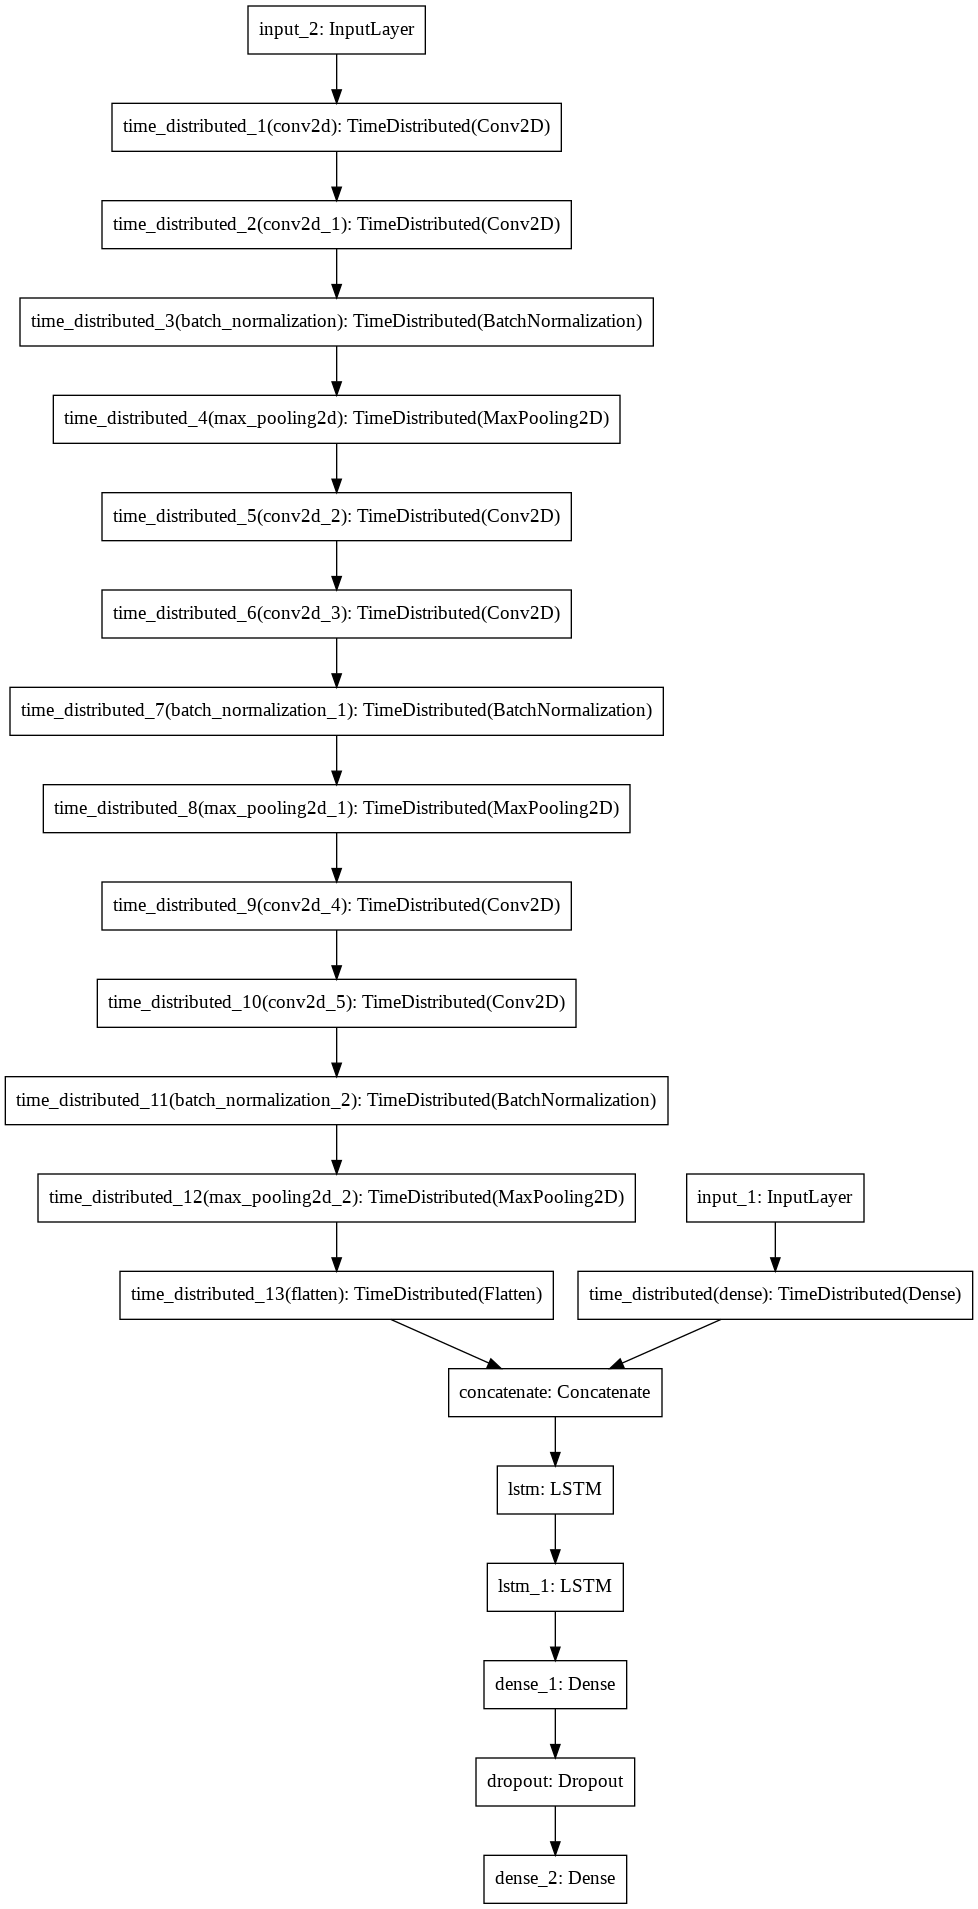

In [14]:
model.summary()
plot_model(model)

In [15]:
# Compiling the Model 
model.compile(loss= 'mse', optimizer= Adam(0.00001),metrics=[mean_acc])

In [18]:
# Training the model 
history_1 = model.fit(train_batches, epochs=1,steps_per_epoch= int((6000-48)/8))

744/744 [==============================] - 683s 918ms/step - loss: 0.0073 - mean_acc: 0.9342


In [19]:
# Convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_1.history) 

# and save to csv: 
hist_csv_file = '/content/gdrive/My Drive/hist_aud_vid_2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [20]:
model.save('gdrive/My Drive/mod_aud_vid.h5') # Saving the model 

In [21]:
model = load_model('gdrive/My Drive/mod_aud_vid.h5',custom_objects={'mean_acc': mean_acc}) # load custom metrics using this dictionary 

In [ ]:
# Generator function for the test data set 
count = 0 # counter variable 

path_ = 'test_frames/' # Path to test data 
anot = pd.read_pickle('annotation_test.pkl') # Getting the test scores 
path_aud = 'output_test' # Getting the Test audio features 

data = os.listdir(path_)

labels = []
pred =[]
mean_acc_test = []

# looping over all test videos
while count < len(data):  
    
  f_name = os.listdir(path_ + data[count]) # getting names of all frames in video folder
  f_name.sort(key= lambda x: int(re.findall(r'[_][\d]+',x)[0].split('_')[1])) # sorting the frame names sequentially 

  frames_1 = [] # list to contain array of all farmes
  for j in f_name: # looping over all frames in a video
      img = cv2.imread(path_ +data[count] +'/'+j)
      frames_1.append(img) # appending each frame array
  frames_1 = np.array(frames_1)/255

  # extracting the labels
  l = np.array([anot['extraversion'][data[count]+'.mp4'],anot['neuroticism'][data[count]+'.mp4'],anot['agreeableness'][data[count]+'.mp4'],anot['conscientiousness'][data[count]+'.mp4'],anot['openness'][data[count]+'.mp4']])
  labels.append(l)
      
  # getting audio features
  aud = pd.read_csv(f'{path_aud}/{data[count]}.wav_st.csv',header=None)
  aud_1 = np.array(aud) 
  
  p = model.predict([frames_1[np.newaxis,...],aud_1[np.newaxis,...]])
  pred.append(p)
  
  mean_acc_test.append(np.mean(1-np.absolute(l-p)))
  count += 1
  
  if count%10 == 0:
    print(count)

In [22]:
np.mean(mean_acc_test) # Getting the Total Mean Accuracy 

NameError: ignored

In [ ]:
# Function to get test Mean accuracy of each trait 
def each_trait_acc(j):  
  trait_label = [i[j] for i in labels]
  trait_pred = [i[0][j] for i in pred]
  return np.mean(1-np.abs(np.array(trait_label)-np.array(trait_pred)))

In [ ]:
each_trait_acc(0) # Mean Accuracy for Extraversion

In [ ]:
each_trait_acc(1) # Mean Accuracy for Neuroticism

In [ ]:
each_trait_acc(2) # Mean Accuracy for Agreeablenss

In [ ]:
each_trait_acc(3) # Mean Accuracy for Conscientiousness

In [ ]:
each_trait_acc(4) # Mean Accuracy for Openenss